In [90]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

# Define the connection string (update with your server details)
conn_str = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=INTERN-DT\\SQLEXPRESS;'  # Double backslashes for server name
    'DATABASE=ecommerce;'
    'Trusted_Connection=yes;'
)

# Establish the connection
conn = pyodbc.connect(conn_str)
cursor = conn.cursor()

# Print a success message
print("Connected to the database successfully!")


Connected to the database successfully!


# List all unique cities where customers are located.

In [91]:
query =  " select distinct customer_city from customers "

cursor.execute(query)

data = cursor.fetchall()


df = pd.DataFrame(data)
df.head()

,0
0,[abadia dos dourados]
1,[abadiania]
2,[abaete]
3,[abaetetuba]
4,[abaiara]


# Count the number of orders placed in 2017

In [92]:
query = " select count(order_id) from orders where year(order_purchase_timestamp) = 2017 "

cursor.execute(query)

data = cursor.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

# the total sales per category

In [93]:
query = """Select upper(p.product_category) as category, round(sum(py.payment_value),2) as total_sales
from products p inner join order_items os 
on p.product_id = os.product_id
inner join payments py
on py.order_id = os.order_id
group by product_category
order by product_category """

cursor.execute(query)

data = cursor.fetchall()


df = pd.DataFrame.from_records(data, columns=["category", "total_sales"])
df

,category,total_sales
0,None,252801.71
1,AGRO INDUSTRIA E COMERCIO,118730.61
2,ART,30992.93
3,ARTS AND CRAFTS,2326.17
4,AUDIO,60324.62
...,...,...
69,STATIONARY STORE,317440.07
70,TECHNICAL BOOKS,24915.44
71,TELEPHONY,486882.05
72,TOYS,619037.69


# Count the number of customers from each state. 

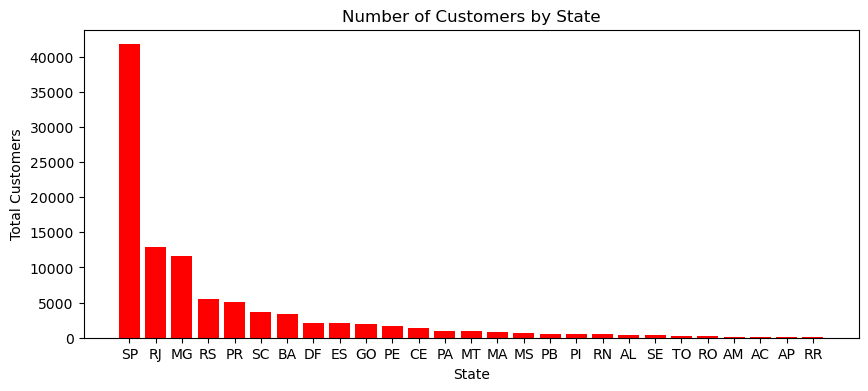

In [94]:
query = """Select customer_state, count(customer_id) as Total
from customers
group by customer_state
order by  Total desc """

cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame.from_records(data, columns=["state", "total_customers"])


plt.figure(figsize=(10, 4))
plt.bar(df["state"], df["total_customers"], color='red')
plt.xlabel("State")
plt.ylabel("Total Customers")
plt.title("Number of Customers by State")
plt.xticks(rotation=0)
plt.show()

# the average number of products per order, grouped by customer city.

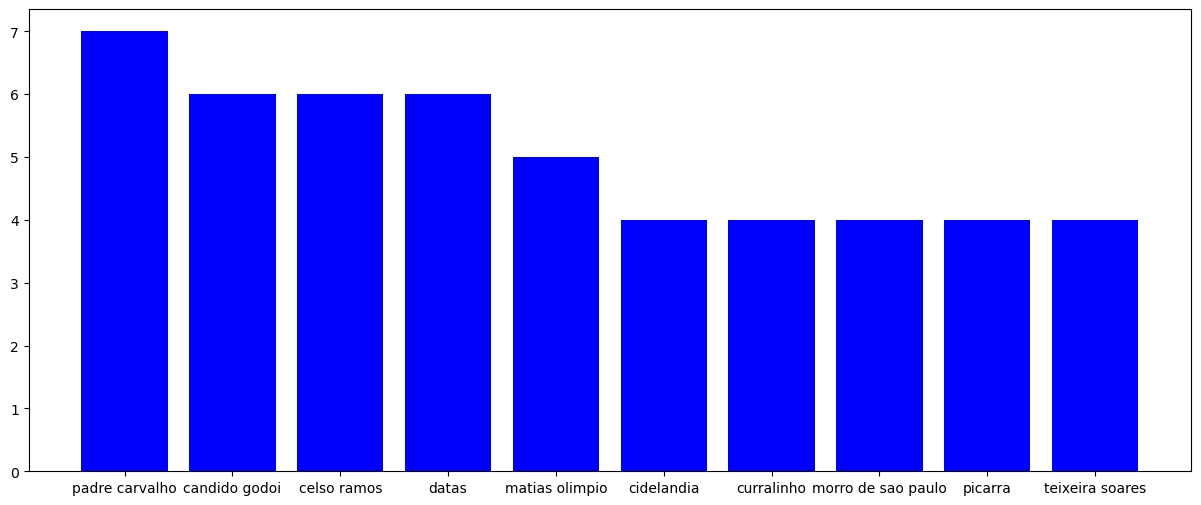

In [95]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select top 10 customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame.from_records(data, columns=["City", "Avg_products_per_order"])

plt.figure(figsize=(15, 6))
plt.bar(df["City"], df["Avg_products_per_order"], color='blue')
plt.show()

# percentage of total revenue contributed by each product category.

In [96]:
query = """
Select upper(p.product_category) as category, 
round((sum(py.payment_value)/(select sum(payment_value) from payments))*100,2) as sales_percentage
from products p join order_items os
on p.product_id = os.product_id
join payments py
on py.order_id = os.order_id
group by product_category
order by sales_percentage desc
"""

cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame.from_records(data,columns = ["Category", "percentage distribution"])
df

,Category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,WATCHES PRESENT,8.93
4,FURNITURE DECORATION,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,FLOWERS,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


# the number of orders per month in 2018

In [112]:
query = """Select Datename(month,order_purchase_timestamp) as monthnames,
Count(order_id) as orders
From orders
where Year(order_purchase_timestamp) = 2018
group by Datename(month,order_purchase_timestamp) """

cursor.execute(query)

data = cursor.fetchall()


df = pd.DataFrame.from_records(data,columns = ["Monthnames", "Order_count"])
df



,Monthnames,Order_count
0,April,6939
1,August,6512
2,February,6728
3,January,7269
4,July,6292
5,June,6167
6,March,7211
7,May,6873
8,October,4
9,September,16


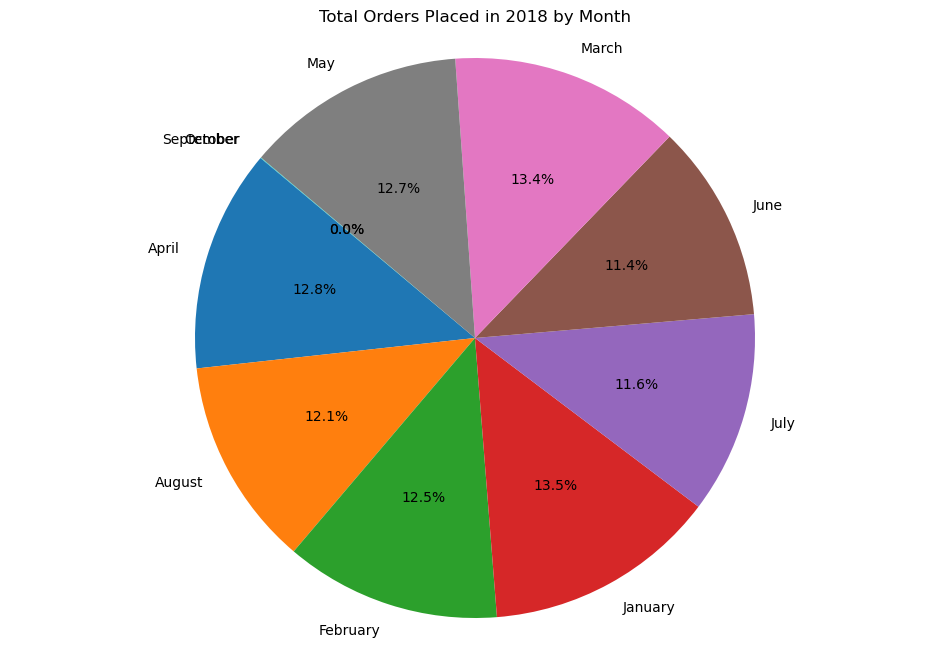

In [111]:
plt.figure(figsize=(12, 8))
plt.pie(df['Order_count'], labels=df['Monthnames'], autopct='%1.1f%%', startangle=140)
plt.title('Total Orders Placed in 2018 by Month')
plt.axis('equal')

plt.show()

# Calculate the total revenue generated by each seller, and rank them by revenue.

In [113]:
query = """ With revenue as
(Select s.seller_state,
round(sum(py.payment_value),2) as total_revenue
From payments py join order_items oi
On py.order_id = oi.order_id
join sellers s
on s.seller_id = oi.seller_id
Group by s.seller_state)

Select *, dense_rank() over(order by total_revenue desc) as ranks
From revenue """

cursor.execute(query)

data = cursor.fetchall()


df = pd.DataFrame.from_records(data,columns = ["seller_state", "total_revenue","rank"])
df

,seller_state,total_revenue,rank
0,SP,13369880.61,1
1,PR,1846047.66,2
2,MG,1564757.80,3
3,RJ,1098242.23,4
4,SC,886745.47,5
5,RS,560236.38,6
6,BA,367899.46,7
7,DF,137784.98,8
8,PE,124894.83,9
9,GO,112183.09,10
